In [ ]:
#|default_exp tiny

BPE saving ..

# Tiny Stories Hackathon
> From Cluster of stars study group

## Data

### Dataset 

In [ ]:
#|export
from datasets import load_dataset
import tiktoken
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor, BoolTensor
from minai import *

from functools import partial
from torch.optim import lr_scheduler

Grab tiny stories data

In [ ]:
#|export
import json
from fastcore.all import *

def load_json(path):
    "Load JSON file from path"
    return json.loads(path.read_text())

In [ ]:
#|export
path = Path.home()/'git/minai/TinyStories_All_data'
path.ls()

(#50) [Path('/home/kappa/git/minai/TinyStories_All_data/data23.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data11.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data47.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data26.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data42.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data07.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data02.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data13.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data01.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data33.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data09.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data21.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data30.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data12.json'),Path('/home/kappa/git/minai/TinyStories_All_data/data15.json'),Path('/home/kappa/git/minai/TinyStories_All_data

In [ ]:
#|export
txt_L = L(load_json(path/'data23.json'))
txt_L[0]

{'story': 'Once upon a time, there was a big cave. In the cave, there lived a big bear. The bear was very bitter. He did not like to play with others. He just wanted to be alone.\nOne day, a little bird flew into the cave. The bird wanted to play with the bear. The bear did not like this. He tried to tease the bird. The bird did not go away. The bird kept trying to play with the bear.\nThen, something unexpected happened. The bear started to laugh. He was not bitter anymore. The little bird and the big bear became friends. They played together every day. They were very happy.',
 'instruction': {'prompt:': 'Write a short story (3-5 paragraphs) which only uses very simple words that a 3 year old child would understand. The story should use the verb "tease", the noun "cave" and the adjective "bitter". The story has the following features: something unexpected happens / there is a plot twist. Remember to only use simple words!',
  'words': ['tease', 'cave', 'bitter'],
  'features': ['Twist

In [ ]:
set(o['source'] for o in txt_L)

{'GPT-3.5', 'GPT-4'}

There are 55390 entries.

In [ ]:
#|export
txt_gpt4 = L([o for o in txt_L if o['source'] == 'GPT-4'])
len(txt_gpt4)

55390

In [ ]:
#|export
txt_raw = ' '.join([o['story'] for o in txt_gpt4])

Once upon a time, there was a big cave. In the cave, there lived a big bear. The bear was very bitter. He did not like to play with others. He just wanted to be alone.
One day, a little bird flew into the cave. The bird wanted to play with the bear. The bear did not like this. He tried to tease the bird. The bird did not go away. The bird kept trying to play with the bear.
Then, something unexpected happened. The bear started to laugh. He was not bitter anymore. The little bird and the big bear became friends. They played together every day. They were very happy. 
Once upon a time there was a young girl named Mary. She loved to explore and never stayed still. One day, when Mary was taking a walk, she stumbled across a giant wreck. She was amazed by what she saw and couldn't believe how big it was.
Mary was about to walk away when a voice suddenly spoke. It was an old man who was sitting on a nearby bench. He said, "Young lady, I know you are curious about the wreck but please don't go 

In [ ]:
import re

In [ ]:
def count_vocab(text):
    "Count unique vocabulary words in text"
    clean_text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())
    words = [w for w in clean_text.split() if w]
    return len(set(words)), set(words)

vocab_count, unique_words = count_vocab(' '.join([o['story'] for o in txt_gpt4]))
vocab_count

11769

So, we have 11769 words.

Let's tokenize them.

In [ ]:
#|export
from minbpe import RegexTokenizer

In [ ]:
#|export
tokenizer = RegexTokenizer()
# tokenizer.train(txt_raw, vocab_size=3000)

tokenizer.load((path/"tok3k_regex.model").name) # loads the model back from disk
tokenizer.encode("hello world") # string -> tokens

[257, 2365, 1597]

In [ ]:
tokenizer.decode([1000, 2000, 2999]) # tokens -> string

' while Fred depend'

In [ ]:
tokenizer.decode(list(range(64, 200))) # tokens -> string

'@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~\x7f������������������������������������������������������������������������'

In [ ]:
txt_raw[:10]

'Once upon '

In [ ]:
tokenizer.encode(txt_raw[:10])

[763, 438, 32]

In [ ]:
#|export
# Code from llm from scratch
class TinyDataset(Dataset):
    def __init__(self, txt, tokenizer, ctx_len):
        self.inp = []
        self.targ = []
#         token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        token_ids = tokenizer.encode(txt)
        for i in range(0, len(token_ids) - ctx_len, ctx_len):
            inp_chunk = token_ids[i:i + ctx_len]
            targ_chunk = token_ids[i + 1: i + ctx_len + 1]
            self.inp.append(torch.tensor(inp_chunk))
            self.targ.append(torch.tensor(targ_chunk))

    def __len__(self): return len(self.inp)

    def __getitem__(self, idx): return self.inp[idx], self.targ[idx]

In [ ]:
55390 // 20

2769

In [ ]:
#|export
# Using around 55k
total_len = int(len(txt_raw) // 20)
total_len

2224565

In [ ]:
#|export
split = int(total_len * .9)
split

2002108

In [ ]:
#|export
ctx_len = 1024
trn_txts = txt_raw[:split]
val_txts = txt_raw[split:total_len]

trn_ds = TinyDataset(trn_txts, tokenizer, ctx_len)
val_ds = TinyDataset(val_txts, tokenizer, ctx_len)
trn_ds[0]

(tensor([ 763,  438,  258,  ..., 1981,  382,  756]),
 tensor([438, 258, 397,  ..., 382, 756, 377]))

In [ ]:
tokenizer.decode(trn_ds[0][0].tolist())[:100]

'Once upon a time, there was a big cave. In the cave, there lived a big bear. The bear was very bitte'

In [ ]:
tokenizer.decode(trn_ds[0][1].tolist())[:100]

' upon a time, there was a big cave. In the cave, there lived a big bear. The bear was very bitter. H'

### DataLoader

In [ ]:
#|export
bs = 8

trn_dl, val_dl = get_dls(trn_ds, val_ds, bs, drop_last=True)
dls = DataLoaders(trn_dl, val_dl)
xb,yb = next(iter(trn_dl))
xb.shape,yb.shape

(torch.Size([8, 1024]), torch.Size([8, 1024]))

## Model

### SDPA

Here's the `MultiHeadAttention` with Causal attention.

In [ ]:
#|export
class SDPACausalAttentionBlock(nn.Module):
    """
    Attention block implementing multi-head causal (masked) attention using
    PyTorch's scaled_dot_product_attention (SDPA).
    """

    def __init__(
        self,
        hidden_dim: int,
        num_heads: int,
        dropout: float = 0.0,
    ):
        """
        Initialize the causal attention block with SDPA implementation.
        """
        super().__init__()
        if hidden_dim % num_heads != 0: raise Exception("hidden_dim not divisible by num_heads")
        self.head_dim = hidden_dim // num_heads
        self.num_heads = num_heads
        self.Wq, self.Wk, self.Wv = nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim)
#         self.Wo = nn.Linear(hidden_dim, hidden_dim)
#         self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor) -> Tensor:
        batch_size, seq_len, hidden_dim = x.shape
        q,k,v = self.Wq(x), self.Wk(x), self.Wv(x) # [batch_size, seq_len, d_out]

        sdpa_ctx = torch.nn.functional.scaled_dot_product_attention(
            q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2), 
            dropout_p=0.0, is_causal=True, scale=None)
        sdpa_ctx = sdpa_ctx.transpose(1,2).view(batch_size, seq_len, -1)
#         return self.dropout(self.Wo(sdpa_ctx))
        return sdpa_ctx

### FeedForward

In [ ]:
#|export
class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_dim, act=nn.ReLU()):
        super().__init__()
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.act = act
        self.l2 = nn.Linear(hidden_dim, in_dim)
    
    def forward(self, x):
        return self.l2(self.act(self.l1(x)))

### Transformer Block

In [ ]:
#|export
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, ctx_len, n_head, drop_out=0, ff_mult=4, qkv_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)
        self.mha = SDPACausalAttentionBlock(hidden_dim=emb_dim, num_heads=n_head, dropout=drop_out)
        self.do = nn.Dropout(drop_out)
        self.ff = FeedForward(emb_dim, emb_dim*ff_mult)
    
    def forward(self, x):
        skip1 = x
        x = self.ln1(x)
        x = self.mha(x)
        x = self.do(x)
        x = x + skip1
        
        skip2 = x
        x = self.ln2(x)
        x = self.ff(x)
        x = self.do(x)
        x = x + skip2
        return x

### GPT model

In [ ]:
#|export
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.do = nn.Dropout(cfg['drop_out'])
        self.tb = nn.Sequential(
            *[TransformerBlock(cfg['emb_dim'], cfg['ctx_len'], cfg['n_head'], cfg['drop_out_tb'],
                              cfg['ff_mult'], cfg['qkv_bias']) for _ in range(cfg['n_tb'])])
        self.final_ln = nn.LayerNorm(cfg['emb_dim'])
        self.final_l  = nn.Linear(cfg['emb_dim'], cfg['vocab_sz'])
    
    def forward(self, x):
        bs, seq_len = x.shape
        tok = self.token_emb(x)
        pos = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = self.do(tok + pos)
        x = self.tb(x)
        x = self.final_ln(x)
        x = self.final_l(x)
        return x

In [ ]:
#|export
def get_total_params(model): return sum(p.numel() for p in model.parameters())

In [ ]:
#|export
def get_total_memory(model):
    total_params = get_total_params(model)
    total_size_bytes = total_params * 4   # Assuming fp32
    # Convert to megabytes
    total_size_mb = total_size_bytes / (1024 * 1024)
    print(f"Total params: {total_params:,}")
    print(f"Total size: {total_size_mb:.2f} MB")

### Text generation

In [ ]:
#|export
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Crop current context if it exceeds the supported context size
        with torch.no_grad(): logits = model(idx_cond)         # (bs, n_tokens, vocab_sz)
        logits = logits[:, -1, :]                              # (bs, vocab_sz)
        probas = torch.softmax(logits, dim=-1)                 # (bs, vocab_sz)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (bs, 1)
        idx = torch.cat((idx, idx_next), dim=1)                # (bs, n_tokens+1)
    return idx

In [ ]:
#|export
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

In [ ]:
#|export
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
#|export
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:].to(def_device)
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)
    return idx

In [ ]:
#|export
class GenerateTextCB(Callback):
    pass

## Learner

In [ ]:
#|export
from torcheval.metrics import  MulticlassAccuracy

In [ ]:
#|export
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, dtype=torch.bfloat16):
        super().__init__(n_inp=n_inp)
        self.dtype=dtype
    
    def before_fit(self, learn): self.scaler = torch.amp.GradScaler('cuda')

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=self.dtype)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

In [ ]:
#|export
def loss_fn(pred, targ): return F.cross_entropy(pred.flatten(0, 1), targ.flatten())

In [ ]:
#|export
cfg = {
    'n_tb': 4,    # num transformer blocks
    'vocab_sz': 3000,
    'emb_dim': 256 // 64,
    'ctx_len': ctx_len,
    'n_head': 4,
    'drop_out': 0,
    'drop_out_tb': 0,  # dropout within transformer blocks
    'ff_mult': 4,
    'qkv_bias': False,
}

In [ ]:
#|export
model = torch.compile(GPTModel(cfg).to(def_device), mode="reduce-overhead")
get_total_memory(model)

Total params: 39,904
Total size: 0.15 MB


In [ ]:
#|export
class LLMMetricsCB(MetricsCB):
    def __init__(self, *ms, **metrics):
        super().__init__(*ms, **metrics)
    
    def after_batch(self, learn):
        x,y,*_ = learn.batch
        for m in self.metrics.values(): m.update(to_cpu(learn.preds.flatten(0, 1)), y.flatten())
        self.loss.update(learn.loss, weight=len(x))

In [ ]:
#|export
class TinyProgressCB(ProgressCB):
#     order = MetricsCB.order+1
    def __init__(self, plot=False, table=True): store_attr()
    
    def _log(self, d): print(d)

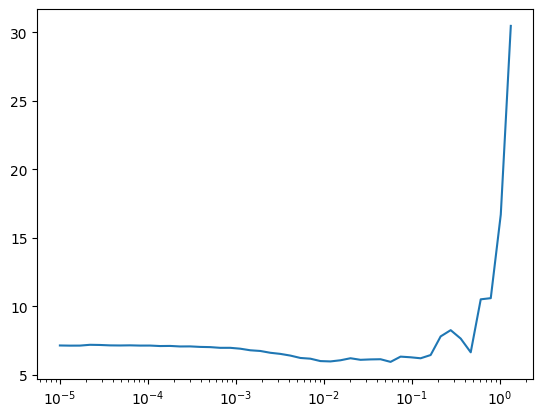

In [ ]:
#|export
# opt = torch.optim.AdamW
# cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=False), DeviceCB(),  MixedPrecision()]
# cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy(device=def_device)), TinyProgressCB(), DeviceCB(), TrainCB()]
# learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs, opt_func=opt)
# learn.lr_find()

In [ ]:
#|export
# set_seed(42)
# lr, epochs = 3e-4, 1
# tmax = epochs * len(dls.train)
# sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
# xtra = [BatchSchedCB(sched)]
# model = torch.compile(GPTModel(cfg).to(def_device), mode="reduce-overhead")
# cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), DeviceCB(),  MixedPrecision()]
# # cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), DeviceCB(), TrainCB()]
# learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs+xtra, opt_func=opt)
# learn.fit(epochs, lr=lr)

/home/kappa/git/minai/minai/core.py:509: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self, learn): self.scaler = torch.amp.GradScaler('cuda')
/home/kappa/miniforge3/envs/torch_latest/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


accuracy,loss,epoch,train,time
0.000,8.161,0,train,00:09
0.001,8.139,0,eval,00:02


/home/kappa/miniforge3/envs/torch_latest/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [ ]:
#|export
# start_context = "Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could"
# model.eval()
# token_ids = generate(
#     model=model.eval(),
#     idx=text_to_token_ids("Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could", tokenizer).to(def_device),
#     max_new_tokens=150,
#     context_size=cfg["ctx_len"],
#     top_k=25,
#     temperature=1
# )

# print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

In [ ]:
#|export
from fastcore.script import *

@call_parse
def main(
    n_tb:Param("Number of transformer blocks", int)=4,
    vocab_sz:Param("Vocabulary size", int)=3000,
    emb_dim:Param("Embedding dimension", int)=64,
    ctx_len:Param("Context length", int)=256,
    n_head:Param("Number of attention heads", int)=4,
    epochs:Param("Number of epochs", int)=1,
    lr:Param("Learning rate", float)=3e-4,
    bs:Param("Batch size", int)=4
):
    "Run training with specified parameters"
    print(n_tb, vocab_sz, emb_dim, ctx_len, n_head, epochs, lr, bs)
    cfg = dict(n_tb=n_tb, vocab_sz=vocab_sz, emb_dim=emb_dim, ctx_len=ctx_len, 
              n_head=n_head, drop_out=0, drop_out_tb=0, ff_mult=4, qkv_bias=False)
    
    model = torch.compile(GPTModel(cfg).to(def_device), mode="reduce-overhead")
    
    cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), TinyProgressCB(), DeviceCB(), MixedPrecision()]
    learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs, opt_func=torch.optim.AdamW)
    
    tmax = epochs * len(dls.train)
    sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
    xtra = [BatchSchedCB(sched)]
    
    learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs+xtra, opt_func=torch.optim.AdamW)
    learn.fit(epochs, lr=lr)
    
    return learn

In [ ]:
from nbdev import nbdev_export; nbdev_export()